# Modelisation de la consommation totale d'énergie

## Import des librairies et du dataset

In [ ]:
!pip install shap
!pip install lime
import shap
import lime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from lime import lime_tabular
from sklearn.dummy import DummyRegressor

In [ ]:
## Import du dataset

%cd "Chemin vers dataset"

df_Building_energy = pd.read_csv("df_Building_energy.csv", sep=',')

C:\Users\33769\OneDrive\Bureau\DataScientist\Projets\Projet_4


## Informations et decription du dataset

In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 60)

In [ ]:
df_Building_energy 

,Unnamed: 0,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,5,Nonresidential COS,Other,West Precinct,810 Virginia St,98101.0,7,DOWNTOWN,47.61623,-122.33657,1999,2,97288,37198,60090,Police Station,88830.0,no secondary use,NaN,no tertiary use,NaN,NaN,136.100006,141.600006,316.299988,320.500000,1.208662e+07,1.258171e+07,0.000,7.371434e+06,4.715182e+06,False,non outlier,301.81,3.10
1,7,NonResidential,Other,Paramount Theatre,911 Pine St,98101.0,7,DOWNTOWN,47.61327,-122.33136,1926,8,102761,0,102761,Other - Entertainment/Public Assembly,102761.0,no secondary use,NaN,no tertiary use,NaN,NaN,61.299999,68.800003,141.699997,152.300003,6.298132e+06,7.067882e+06,2276286.500,3.636655e+06,3.851890e+05,False,non outlier,221.51,2.16
2,15,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,98154.0,7,DOWNTOWN,47.60649,-122.33297,2004,11,412000,57000,355000,Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,50.799999,51.099998,155.600006,156.000000,1.858886e+07,1.870691e+07,737559.500,1.785130e+07,0.000000e+00,False,non outlier,181.38,0.44
3,16,NonResidential,Other,Downtown Seattle YMCA,909 4th Avenue,98104.0,7,DOWNTOWN,47.60546,-122.33279,1930,6,103911,0,103911,Fitness Center/Health Club/Gym,90000.0,Office,40000.0,Swimming Pool,0.0,NaN,76.599998,78.400002,157.399994,159.600006,9.956396e+06,1.019212e+07,4592347.500,4.453868e+06,9.101800e+05,False,non outlier,433.86,4.18
4,18,NonResidential,Mixed Use Property,The Rainier Club,820 4th Ave.,98104.0,7,DOWNTOWN,47.60515,-122.33159,1907,5,57452,0,57452,Social/Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.0,NaN,132.399994,137.100006,280.700012,285.000000,7.606084e+06,7.877219e+06,1776201.875,3.764791e+06,2.065091e+06,False,non outlier,273.02,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,3371,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,98108.0,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1,12294,0,12294,Office,12294.0,no secondary use,NaN,no tertiary use,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.000,5.242709e+05,3.254750e+05,True,non outlier,20.94,1.70
1509,3372,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,98104.0,2,DOWNTOWN,47.59625,-122.32283,2004,1,16000,0,16000,Other - Recreation,16000.0,no secondary use,NaN,no tertiary use,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.000,3.965461e+05,5.537300e+05,False,non outlier,32.17,2.01
1510,3373,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,98101.0,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.000,1.792159e+06,3.973739e+06,False,non outlier,223.54,16.99
1511,3374,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,98108.0,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.000,3.488702e+05,3.706010e+05,False,non outlier,22.11,1.57


In [ ]:
del df_Building_energy["Unnamed: 0"]

In [ ]:
df_Building_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1513 non-null   object 
 1   PrimaryPropertyType              1513 non-null   object 
 2   PropertyName                     1513 non-null   object 
 3   Address                          1513 non-null   object 
 4   ZipCode                          1513 non-null   float64
 5   CouncilDistrictCode              1513 non-null   int64  
 6   Neighborhood                     1513 non-null   object 
 7   Latitude                         1513 non-null   float64
 8   Longitude                        1513 non-null   float64
 9   YearBuilt                        1513 non-null   int64  
 10  NumberofFloors                   1513 non-null   int64  
 11  PropertyGFATotal                 1513 non-null   int64  
 12  PropertyGFAParking  

In [ ]:
df_Building_energy.describe()

,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1.513000e+03,1513.000000,1.513000e+03,1.508000e+03,771.000000,307.000000,973.000000,1510.000000,1510.000000,1511.000000,1511.000000,1.511000e+03,1.510000e+03,1.511000e+03,1.511000e+03,1.511000e+03,1511.000000,1511.000000
mean,98117.202247,4.256444,47.614898,-122.333016,1961.851289,3.832783,1.165883e+05,12389.051553,1.041992e+05,9.769449e+04,36431.464717,14283.369377,65.985612,71.785497,74.182782,177.380477,179.487359,8.348372e+06,7.910338e+06,4.765359e+05,5.914067e+06,1.837612e+06,175.607737,1.552052
std,18.101531,2.195248,0.049130,0.025116,32.220096,6.447011,3.057704e+05,42659.059222,2.931479e+05,2.870274e+05,69786.917579,37104.179235,28.500953,76.636822,77.596503,193.728032,193.667963,3.148852e+07,2.275073e+07,5.675696e+06,2.169826e+07,9.718641e+06,777.388349,2.374095
min,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000,-0.020000
25%,98105.000000,2.000000,47.582170,-122.343380,1931.000000,1.000000,2.884100e+04,0.000000,2.793300e+04,2.508025e+04,5045.500000,2583.500000,49.000000,32.349999,34.500000,74.000000,77.099998,1.158892e+06,1.233055e+06,0.000000e+00,6.956805e+05,0.000000e+00,18.750000,0.330000
50%,98114.000000,4.000000,47.611660,-122.332820,1965.000000,2.000000,4.736800e+04,0.000000,4.568000e+04,4.219000e+04,11520.000000,5931.000000,75.000000,50.049999,52.450001,126.000000,130.399994,2.371575e+06,2.498229e+06,0.000000e+00,1.537923e+06,3.991220e+05,46.460000,0.800000
75%,98125.000000,7.000000,47.649130,-122.321570,1988.000000,4.000000,9.944000e+04,0.000000,9.243700e+04,8.811825e+04,30232.500000,12379.500000,89.000000,78.375002,82.475000,204.050003,205.000000,6.553759e+06,6.768524e+06,0.000000e+00,4.788646e+06,1.265570e+06,123.560000,1.705000
max,98199.000000,7.000000,47.733870,-122.258640,2015.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


### Creation d'une feature % of energy from SteamUse, Electricity and Natural Gas

In [ ]:
df_Building_energy["part_SteamUse"] = df_Building_energy["SteamUse(kBtu)"]/(df_Building_energy["SteamUse(kBtu)"]
                                                                            +df_Building_energy["Electricity(kBtu)"]
                                                                            +df_Building_energy["NaturalGas(kBtu)"])

df_Building_energy["part_NaturalGas"] = df_Building_energy["NaturalGas(kBtu)"]/(df_Building_energy["SteamUse(kBtu)"]
                                                                            +df_Building_energy["Electricity(kBtu)"]
                                                                            +df_Building_energy["NaturalGas(kBtu)"])

df_Building_energy["part_Electricity"]  = df_Building_energy["Electricity(kBtu)"]/(df_Building_energy["SteamUse(kBtu)"]
                                                                            +df_Building_energy["Electricity(kBtu)"]
                                                                            +df_Building_energy["NaturalGas(kBtu)"])

In [ ]:
df_Building_energy

,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity
0,Nonresidential COS,Other,West Precinct,810 Virginia St,98101.0,7,DOWNTOWN,47.61623,-122.33657,1999,2,97288,37198,60090,Police Station,88830.0,no secondary use,NaN,no tertiary use,NaN,NaN,136.100006,141.600006,316.299988,320.500000,1.208662e+07,1.258171e+07,0.000,7.371434e+06,4.715182e+06,False,non outlier,301.81,3.10,0.000000,0.390116,0.609884
1,NonResidential,Other,Paramount Theatre,911 Pine St,98101.0,7,DOWNTOWN,47.61327,-122.33136,1926,8,102761,0,102761,Other - Entertainment/Public Assembly,102761.0,no secondary use,NaN,no tertiary use,NaN,NaN,61.299999,68.800003,141.699997,152.300003,6.298132e+06,7.067882e+06,2276286.500,3.636655e+06,3.851890e+05,False,non outlier,221.51,2.16,0.361423,0.061159,0.577418
2,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,98154.0,7,DOWNTOWN,47.60649,-122.33297,2004,11,412000,57000,355000,Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,50.799999,51.099998,155.600006,156.000000,1.858886e+07,1.870691e+07,737559.500,1.785130e+07,0.000000e+00,False,non outlier,181.38,0.44,0.039678,0.000000,0.960322
3,NonResidential,Other,Downtown Seattle YMCA,909 4th Avenue,98104.0,7,DOWNTOWN,47.60546,-122.33279,1930,6,103911,0,103911,Fitness Center/Health Club/Gym,90000.0,Office,40000.0,Swimming Pool,0.0,NaN,76.599998,78.400002,157.399994,159.600006,9.956396e+06,1.019212e+07,4592347.500,4.453868e+06,9.101800e+05,False,non outlier,433.86,4.18,0.461246,0.091417,0.447337
4,NonResidential,Mixed Use Property,The Rainier Club,820 4th Ave.,98104.0,7,DOWNTOWN,47.60515,-122.33159,1907,5,57452,0,57452,Social/Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.0,NaN,132.399994,137.100006,280.700012,285.000000,7.606084e+06,7.877219e+06,1776201.875,3.764791e+06,2.065091e+06,False,non outlier,273.02,4.75,0.233524,0.271505,0.494971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,98108.0,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1,12294,0,12294,Office,12294.0,no secondary use,NaN,no tertiary use,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.000,5.242709e+05,3.254750e+05,True,non outlier,20.94,1.70,0.000000,0.383026,0.616974
1509,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,98104.0,2,DOWNTOWN,47.59625,-122.32283,2004,1,16000,0,16000,Other - Recreation,16000.0,no secondary use,NaN,no tertiary use,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.000,3.965461e+05,5.537300e+05,False,non outlier,32.17,2.01,0.000000,0.582704,0.417296
1510,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,98101.0,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.000,1.792159e+06,3.973739e+06,False,non outlier,223.54,16.99,0.000000,0.689180,0.310820
1511,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,98108.0,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,55.500000,105.30000

## Préparation du dataset pour modelisation

In [ ]:
df_modelisation = df_Building_energy.copy()

# supression des colonnes non utilisées pour la modelisation

del df_modelisation["BuildingType"]
del df_modelisation["PropertyName"]
del df_modelisation["Address"]
del df_modelisation["DefaultData"]
del df_modelisation["ENERGYSTARScore"]
del df_modelisation["SteamUse(kBtu)"]
del df_modelisation["NaturalGas(kBtu)"]
del df_modelisation["Electricity(kBtu)"]
del df_modelisation["SiteEUI(kBtu/sf)"]
del df_modelisation['SiteEUIWN(kBtu/sf)']
del df_modelisation['SourceEUI(kBtu/sf)']
del df_modelisation['SourceEUIWN(kBtu/sf)']
del df_modelisation['SiteEnergyUse(kBtu)']


# imputation des Nan des aires des usages secondaires et tertiaires par 0

df_modelisation['ThirdLargestPropertyUseTypeGFA'] = df_modelisation['ThirdLargestPropertyUseTypeGFA'].fillna(0)
df_modelisation['SecondLargestPropertyUseTypeGFA'] = df_modelisation['SecondLargestPropertyUseTypeGFA'].fillna(0)

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'SiteEnergyUseWN(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'part_SteamUse', 'part_NaturalGas',
       'part_Electricity'],
      dtype='object')

### suppression des outliers

In [ ]:
df_modelisation["Outlier"].value_counts()

non outlier     1498
Low outlier       13
High outlier       2
Name: Outlier, dtype: int64

In [ ]:
df_modelisation[df_modelisation["Outlier"]=="Low outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity
320,Retail Store,98105.0,4,NORTHEAST,47.66178,-122.31812,1987,2,69492,0,69492,Retail Store,69800.0,Other,0.0,no tertiary use,0.0,3.189628e+05,Low outlier,2.22,0.03,0.0,0.000000,1.000000
383,Large Office,98104.0,2,DOWNTOWN,47.59878,-122.33458,1913,7,154159,0,154159,Office,193154.0,no secondary use,0.0,no tertiary use,0.0,1.134876e+07,Low outlier,29.43,0.19,0.0,0.175759,0.824241
628,K-12 School,98109.0,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1,35805,0,35805,K-12 School,35805.0,no secondary use,0.0,no tertiary use,0.0,4.314717e+05,Low outlier,11.54,0.32,0.0,0.428403,0.571597
693,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1,39900,0,39900,Retail Store,25000.0,Non-Refrigerated Warehouse,15000.0,no tertiary use,0.0,1.454688e+05,Low outlier,5.46,0.14,0.0,0.663124,0.336876
775,Small- and Mid-Sized Office,98101.0,7,DOWNTOWN,47.61119,-122.33581,1903,3,57720,0,57720,Office,25000.0,no secondary use,0.0,no tertiary use,0.0,2.410550e+04,Low outlier,0.17,0.00,0.0,0.000000,1.000000
817,Other,98101.0,7,DOWNTOWN,47.60711,-122.33886,1900,3,49760,0,49760,Other,24019.0,no secondary use,0.0,no tertiary use,0.0,4.429350e+04,Low outlier,0.31,0.01,0.0,0.000000,1.000000
932,Worship Facility,98126.0,1,SOUTHWEST,47.51709,-122.37797,1971,1,23772,0,23772,Worship Facility,23772.0,no secondary use,0.0,no tertiary use,0.0,1.008417e+05,Low outlier,0.70,0.03,0.0,0.000000,1.000000
1027,Small- and Mid-Sized Office,98133.0,3,CENTRAL,47.59973,-122.31331,1947,1,45068,0,45068,Office,45068.0,no secondary use,0.0,no tertiary use,0.0,3.092140e+05,Low outlier,8.59,0.19,0.0,0.502263,0.497737
1131,K-12 School,98122.0,3,CENTRAL,47.60885,-122.29990,1929,2,24152,0,24152,K-12 School,24152.0,no secondary use,0.0,no tertiary use,0.0,1.613634e+05,Low outlier,1.12,0.05,0.0,0.000000,1.000000
1166,Other,98134.0,2,GREATER DUWAMISH,47.58788,-122.33458,1910,3,27690,0,27690,Other,24717.0,Parking,0.0,no tertiary use,0.0,1.726000e+04,Low outlier,0.12,0.00,0.0,0.000000,1.000000


In [ ]:
df_modelisation[df_modelisation["Outlier"]=="High outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity
167,Large Office,98101.0,7,DOWNTOWN,47.60642,-122.33581,1958,6,172842,25920,146922,Office,99890.0,Data Center,39336.0,Parking,25000.0,41650404.0,High outlier,362.66,2.10,0.0,0.038765,0.961235
445,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,4,129551,42500,87051,Office,82273.0,Parking,42500.0,Data Center,4778.0,27137190.0,High outlier,189.18,1.46,0.0,0.000000,1.000000


In [ ]:
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='Low outlier'].index, inplace=True)
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='High outlier'].index, inplace=True)
del df_modelisation['Outlier']

## Preprocessing

### Encodage variables qualitatives

Il ne s'agit que de variables ordinales, nous utiliserons ordinalencoder ou onehotencoder, sauf pour les etages ou nous créerons 4 categories  :0 etage (terrain) 1,2 etages(maison), 2 à 5 étages(petit immeuble) et 6 etages et au dessus(immeuble).

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'part_SteamUse', 'part_NaturalGas', 'part_Electricity'],
      dtype='object')

In [ ]:
# création des 3 classes de batiments par étage

In [ ]:
df_modelisation['NumberofFloors'].unique()

array([ 2,  8, 11,  6,  5, 10, 19,  7,  1,  3, 12,  4, 15, 25, 33, 23, 17,
       20, 36, 16, 22, 47, 41, 29, 34, 14, 49, 37, 42, 63, 13, 18, 24, 21,
       55, 46, 30, 56,  9,  0, 76, 27, 99], dtype=int64)

In [ ]:
df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors']


In [ ]:
classes = {range(1, 2): 1, range(3, 5): 2, range(6, 1000): 3}

df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors'].apply(lambda x: next((v for k, v in classes.items() if x in k), 0))

In [ ]:
df_modelisation['NumberofFloorsClass'].unique()

array([0, 3, 1, 2], dtype=int64)

In [ ]:
df_modelisation[['NumberofFloorsClass', 'NumberofFloors']].head(20)

,NumberofFloorsClass,NumberofFloors
0,0,2
1,3,8
2,3,11
3,3,6
4,0,5
5,3,10
6,3,19
7,0,2
8,3,7
9,0,2


In [ ]:
encodcol = ['PrimaryPropertyType',
             'ZipCode',
            'CouncilDistrictCode',
             'Neighborhood',
             'LargestPropertyUseType',
             'SecondLargestPropertyUseType',
             'ThirdLargestPropertyUseType',
             "NumberofFloorsClass"]

In [ ]:
def encodage(df):
#    df['ZipCode'] = df['ZipCode'].astype(object)
    for col in encodcol:
        #df = pd.get_dummies(df, columns = None)
        df = pd.get_dummies(df, columns =encodcol)
        return df

In [ ]:
df_modelisation

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,NumberofFloorsClass
0,Other,98101.0,7,DOWNTOWN,47.61623,-122.33657,1999,2,97288,37198,60090,Police Station,88830.0,no secondary use,0.0,no tertiary use,0.0,1.258171e+07,301.81,3.10,0.000000,0.390116,0.609884,0
1,Other,98101.0,7,DOWNTOWN,47.61327,-122.33136,1926,8,102761,0,102761,Other - Entertainment/Public Assembly,102761.0,no secondary use,0.0,no tertiary use,0.0,7.067882e+06,221.51,2.16,0.361423,0.061159,0.577418,3
2,Other,98154.0,7,DOWNTOWN,47.60649,-122.33297,2004,11,412000,57000,355000,Library,364913.0,Parking,49000.0,Data Center,1074.0,1.870691e+07,181.38,0.44,0.039678,0.000000,0.960322,3
3,Other,98104.0,7,DOWNTOWN,47.60546,-122.33279,1930,6,103911,0,103911,Fitness Center/Health Club/Gym,90000.0,Office,40000.0,Swimming Pool,0.0,1.019212e+07,433.86,4.18,0.461246,0.091417,0.447337,3
4,Mixed Use Property,98104.0,7,DOWNTOWN,47.60515,-122.33159,1907,5,57452,0,57452,Social/Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.0,7.877219e+06,273.02,4.75,0.233524,0.271505,0.494971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Office,98108.0,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1,12294,0,12294,Office,12294.0,no secondary use,0.0,no tertiary use,0.0,9.430032e+05,20.94,1.70,0.000000,0.383026,0.616974,1
1509,Other,98104.0,2,DOWNTOWN,47.59625,-122.32283,2004,1,16000,0,16000,Other - Recreation,16000.0,no secondary use,0.0,no tertiary use,0.0,1.053706e+06,32.17,2.01,0.000000,0.582704,0.417296,1
1510,Other,98101.0,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,6.053764e+06,223.54,16.99,0.000000,0.689180,0.310820,1
1511,Mixed Use Property,98108.0,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,7.828413e+05,22.11,1.57,0.000000,0.515102,0.484898,1


In [ ]:
def imputation(df):
    return df.dropna(axis=0)

In [ ]:
scaler = StandardScaler()
df_modelisation[["Latitude",
                 "Longitude",
                 "YearBuilt",
                 "PropertyGFATotal",
                "PropertyGFAParking",
                "PropertyGFABuilding(s)",
                "LargestPropertyUseTypeGFA",
                "SecondLargestPropertyUseTypeGFA",
                "ThirdLargestPropertyUseTypeGFA"]] = scaler.fit_transform(df_modelisation[["Latitude",
                 "Longitude",
                 "YearBuilt",
                 "PropertyGFATotal",
                "PropertyGFAParking",
                "PropertyGFABuilding(s)",
                "LargestPropertyUseTypeGFA",
                "SecondLargestPropertyUseTypeGFA",
                "ThirdLargestPropertyUseTypeGFA"]])

In [ ]:
df_modelisation

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,NumberofFloorsClass
0,Other,98101.0,7,DOWNTOWN,0.024120,-0.140986,1.150325,2,-0.064669,0.577361,-0.151439,Police Station,-0.032403,no secondary use,-0.350952,no tertiary use,-0.164032,1.258171e+07,301.81,3.10,0.000000,0.390116,0.609884,0
1,Other,98101.0,7,DOWNTOWN,-0.036051,0.066406,-1.121817,8,-0.046847,-0.291065,-0.006520,Other - Entertainment/Public Assembly,0.015919,no secondary use,-0.350952,no tertiary use,-0.164032,7.067882e+06,221.51,2.16,0.361423,0.061159,0.577418,3
2,Other,98154.0,7,DOWNTOWN,-0.173874,0.002317,1.305951,11,0.960097,1.039659,0.850137,Library,0.925237,Parking,0.569337,Data Center,-0.103437,1.870691e+07,181.38,0.44,0.039678,0.000000,0.960322,3
3,Other,98104.0,7,DOWNTOWN,-0.194811,0.009483,-0.997317,6,-0.043103,-0.291065,-0.002614,Fitness Center/Health Club/Gym,-0.028345,Office,0.400304,Swimming Pool,-0.164032,1.019212e+07,433.86,4.18,0.461246,0.091417,0.447337,3
4,Mixed Use Property,98104.0,7,DOWNTOWN,-0.201113,0.057251,-1.713197,5,-0.194383,-0.291065,-0.160399,Social/Meeting Hall,-0.283494,Restaurant,-0.059746,Office,0.385552,7.877219e+06,273.02,4.75,0.233524,0.271505,0.494971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Office,98108.0,2,GREATER DUWAMISH,-0.972149,0.855372,0.870198,1,-0.341426,-0.291065,-0.313765,Office,-0.297882,no secondary use,-0.350952,no tertiary use,-0.164032,9.430032e+05,20.94,1.70,0.000000,0.383026,0.616974,1
1509,Other,98104.0,2,DOWNTOWN,-0.382031,0.405956,1.305951,1,-0.329359,-0.291065,-0.301178,Other - Recreation,-0.285027,no secondary use,-0.350952,no tertiary use,-0.164032,1.053706e+06,32.17,2.01,0.000000,0.582704,0.417296,1
1510,Other,98101.0,7,MAGNOLIA / QUEEN ANNE,0.434945,-0.987671,0.372194,1,-0.338616,-0.291065,-0.310834,Other - Recreation,-0.314222,Fitness Center/Health Club/Gym,-0.246264,Swimming Pool,-0.164032,6.053764e+06,223.54,16.99,0.000000,0.689180,0.310820,1
1511,Mixed Use Property,98108.0,1,GREATER DUWAMISH,-1.762902,0.347042,0.839072,1,-0.335542,-0.291065,-0.307628,Other - Recreation,-0.317629,Fitness Center/Health Club/Gym,-0.228854,Pre-school/Daycare,-0.136725,7.828413e+05,22.11,1.57,0.000000,0.515102,0.484898,1


In [ ]:
def preprocessing_CO2(df):
    df = encodage(df)
    df = imputation(df)
    X = df.drop(["TotalGHGEmissions","GHGEmissionsIntensity", 'NumberofFloors', 'SiteEnergyUseWN(kBtu)'], axis=1)
    y = df["TotalGHGEmissions"]
    return X,y

In [ ]:
def preprocessing_energy(df):
    df = encodage(df)
    df = imputation(df)
    X = df.drop(["TotalGHGEmissions","GHGEmissionsIntensity", 'NumberofFloors', 'SiteEnergyUseWN(kBtu)'], axis=1)
    y = df['SiteEnergyUseWN(kBtu)']
    return X,y

In [ ]:
df_modelisation

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,NumberofFloorsClass
0,Other,98101.0,7,DOWNTOWN,0.024120,-0.140986,1.150325,2,-0.064669,0.577361,-0.151439,Police Station,-0.032403,no secondary use,-0.350952,no tertiary use,-0.164032,1.258171e+07,301.81,3.10,0.000000,0.390116,0.609884,0
1,Other,98101.0,7,DOWNTOWN,-0.036051,0.066406,-1.121817,8,-0.046847,-0.291065,-0.006520,Other - Entertainment/Public Assembly,0.015919,no secondary use,-0.350952,no tertiary use,-0.164032,7.067882e+06,221.51,2.16,0.361423,0.061159,0.577418,3
2,Other,98154.0,7,DOWNTOWN,-0.173874,0.002317,1.305951,11,0.960097,1.039659,0.850137,Library,0.925237,Parking,0.569337,Data Center,-0.103437,1.870691e+07,181.38,0.44,0.039678,0.000000,0.960322,3
3,Other,98104.0,7,DOWNTOWN,-0.194811,0.009483,-0.997317,6,-0.043103,-0.291065,-0.002614,Fitness Center/Health Club/Gym,-0.028345,Office,0.400304,Swimming Pool,-0.164032,1.019212e+07,433.86,4.18,0.461246,0.091417,0.447337,3
4,Mixed Use Property,98104.0,7,DOWNTOWN,-0.201113,0.057251,-1.713197,5,-0.194383,-0.291065,-0.160399,Social/Meeting Hall,-0.283494,Restaurant,-0.059746,Office,0.385552,7.877219e+06,273.02,4.75,0.233524,0.271505,0.494971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Office,98108.0,2,GREATER DUWAMISH,-0.972149,0.855372,0.870198,1,-0.341426,-0.291065,-0.313765,Office,-0.297882,no secondary use,-0.350952,no tertiary use,-0.164032,9.430032e+05,20.94,1.70,0.000000,0.383026,0.616974,1
1509,Other,98104.0,2,DOWNTOWN,-0.382031,0.405956,1.305951,1,-0.329359,-0.291065,-0.301178,Other - Recreation,-0.285027,no secondary use,-0.350952,no tertiary use,-0.164032,1.053706e+06,32.17,2.01,0.000000,0.582704,0.417296,1
1510,Other,98101.0,7,MAGNOLIA / QUEEN ANNE,0.434945,-0.987671,0.372194,1,-0.338616,-0.291065,-0.310834,Other - Recreation,-0.314222,Fitness Center/Health Club/Gym,-0.246264,Swimming Pool,-0.164032,6.053764e+06,223.54,16.99,0.000000,0.689180,0.310820,1
1511,Mixed Use Property,98108.0,1,GREATER DUWAMISH,-1.762902,0.347042,0.839072,1,-0.335542,-0.291065,-0.307628,Other - Recreation,-0.317629,Fitness Center/Health Club/Gym,-0.228854,Pre-school/Daycare,-0.136725,7.828413e+05,22.11,1.57,0.000000,0.515102,0.484898,1


In [ ]:
df_X, df_y = preprocessing_energy(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

**Etant donné la petite taille du dataset, la continuité de la variable target, la non normalité des données et la présence de variables qualitatives et quantitatives nous allons nous tourner vers des modeles de regression SVR et kneighbour regressor, puis randomforest regressor ou boosting**

### Prediction Energie

In [ ]:
df_X, df_y = preprocessing_energy(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

#### K Neighbours Regressor

In [ ]:
hyper_params_KNR = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10],
                'weights':["uniform", "distance"],
                'algorithm':["auto", "ball_tree", "kd_tree", "brute"]
               }

In [ ]:
KNR_model = KNeighborsRegressor()
grid_KNR = GridSearchCV(KNR_model, hyper_params_KNR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_KNR.fit(X_train,y_train)
print(grid_KNR.best_params_)

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}
Wall time: 12.2 s


In [ ]:
%%time
KNR_model = grid_KNR.best_estimator_
KNR_model.fit(X_train,y_train)

Wall time: 12 ms


KNeighborsRegressor(algorithm='ball_tree', n_neighbors=9, weights='distance')

In [ ]:
%%time
y_pred_KNR = KNR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_KNR))
print(mean_squared_error(y_test, y_pred_KNR))
print(r2_score(y_test, y_pred_KNR))

5789576.372093087
784954042371543.4
0.28634695530766696
Wall time: 98 ms


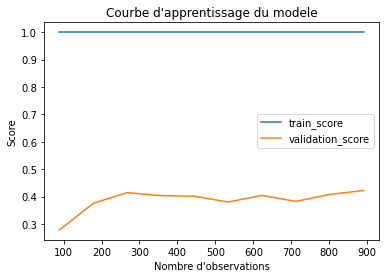

In [ ]:
N, train_score, val_score = learning_curve(KNR_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_KNR)

,0
3.340853e+06,1.310237e+06
1.726237e+06,2.109094e+06
2.202116e+06,2.832228e+06
1.415743e+06,1.103595e+06
1.987520e+06,2.300589e+06
...,...
3.880705e+06,2.001526e+06
1.428270e+07,2.574702e+07
1.674951e+06,8.194931e+05
2.931014e+06,3.612527e+06


#### Random Forest Regressor

In [ ]:
hyper_params_RFR = {'n_estimators' : [20, 50, 100, 150],
                'criterion':["squared_error", "absolute_error"]
               }

In [ ]:
RFR_model = RandomForestRegressor()
grid_RFR = GridSearchCV(RFR_model, hyper_params_RFR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_RFR.fit(X_train,y_train)

Wall time: 6min 12s


GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'n_estimators': [20, 50, 100, 150]},
             scoring='r2')

In [ ]:
%%time
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)

Wall time: 40.9 s


RandomForestRegressor(criterion='absolute_error')

In [ ]:
%%time
y_pred_RFR = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_RFR))
print(mean_squared_error(y_test, y_pred_RFR))
print(r2_score(y_test, y_pred_RFR))

4256126.5440265825
463449446684305.6
0.5786478050511381
Wall time: 12.9 ms


In [ ]:
pd.DataFrame(y_test, y_pred_RFR)

,0
5.074460e+06,1.310237e+06
7.532263e+06,2.109094e+06
3.038811e+06,2.832228e+06
1.791746e+06,1.103595e+06
4.040293e+06,2.300589e+06
...,...
2.267709e+06,2.001526e+06
1.760351e+07,2.574702e+07
1.586682e+06,8.194931e+05
3.242765e+06,3.612527e+06


#### Support Vector Regressor

In [ ]:
hyper_params_SVR = {'gamma' : ["scale", "auto"],
                'C':[1, 10, 100, 1000, 10000, 100000]
               }

In [ ]:
SVR_model = SVR()
grid_SVR = GridSearchCV(SVR_model, hyper_params_SVR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_SVR.fit(X_train,y_train)
print(grid_SVR.best_params_)

{'C': 100000, 'gamma': 'scale'}
Wall time: 4.93 s


In [ ]:
%%time
SVR_model = grid_SVR.best_estimator_
SVR_model.fit(X_train,y_train)

Wall time: 98.7 ms


SVR(C=100000)

In [ ]:
%%time
y_pred_SVR = SVR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_SVR))
print(mean_squared_error(y_test, y_pred_SVR))
print(r2_score(y_test, y_pred_SVR))

7063527.567208325
1109432635709489.4
-0.008657750156991995
Wall time: 61.3 ms


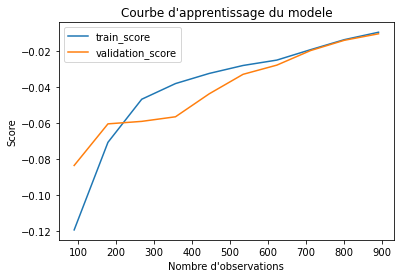

In [ ]:
N, train_score, val_score = learning_curve(SVR_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_SVR)

,0
2.548850e+06,1.310237e+06
2.889117e+06,2.109094e+06
2.597040e+06,2.832228e+06
1.954464e+06,1.103595e+06
2.929295e+06,2.300589e+06
...,...
2.200561e+06,2.001526e+06
5.744867e+06,2.574702e+07
2.005729e+06,8.194931e+05
2.378274e+06,3.612527e+06


#### AdaBoostRegressor

In [ ]:
hyper_params_ADA = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
ADA_model = AdaBoostRegressor()
grid_ADA = GridSearchCV(ADA_model, hyper_params_ADA, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_ADA.fit(X_train,y_train)
print(grid_ADA.best_params_)

{'learning_rate': 1, 'n_estimators': 20}
Wall time: 12.1 s


In [ ]:
%%time
ADA_model = grid_ADA.best_estimator_
ADA_model.fit(X_train,y_train)

Wall time: 120 ms


AdaBoostRegressor(learning_rate=1, n_estimators=20)

In [ ]:
%%time
y_pred_ADA = ADA_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_ADA))
print(mean_squared_error(y_test, y_pred_ADA))
print(r2_score(y_test, y_pred_ADA))

8101127.936307238
759897885200883.4
0.30912714610598047
Wall time: 4.49 ms


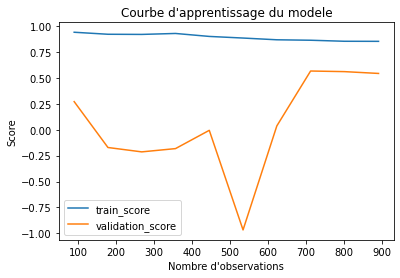

In [ ]:
N, train_score, val_score = learning_curve(ADA_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_ADA)

,0
6.230288e+06,1.310237e+06
8.889795e+06,2.109094e+06
6.230288e+06,2.832228e+06
6.230288e+06,1.103595e+06
6.230288e+06,2.300589e+06
...,...
6.230288e+06,2.001526e+06
2.085103e+07,2.574702e+07
6.230288e+06,8.194931e+05
6.230288e+06,3.612527e+06


#### GradientBoostingRegressor

In [ ]:
hyper_params_GBR = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
GB_model = GradientBoostingRegressor()
grid_GBR = GridSearchCV(GB_model , hyper_params_GBR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_GBR.fit(X_train,y_train)
print(grid_GBR.best_params_)

{'learning_rate': 1, 'n_estimators': 20}
Wall time: 14.9 s


overflow encountered in square


In [ ]:
%%time
GBR_model = grid_GBR.best_estimator_
GBR_model.fit(X_train,y_train)

Wall time: 85 ms


GradientBoostingRegressor(learning_rate=1, n_estimators=20)

In [ ]:
%%time
y_pred_GBR = GBR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_GBR))
print(mean_squared_error(y_test, y_pred_GBR))
print(r2_score(y_test, y_pred_GBR))

5514324.135945194
742341011128421.0
0.32508924829382047
Wall time: 2.13 ms


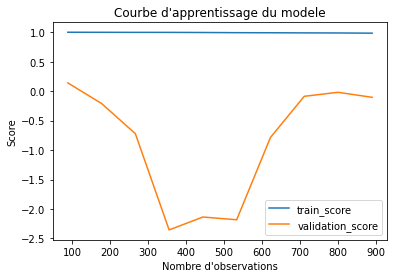

In [ ]:
N, train_score, val_score = learning_curve(GBR_model , X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_GBR)

,0
5.585628e+06,1.310237e+06
5.451614e+06,2.109094e+06
1.212836e+06,2.832228e+06
1.752806e+06,1.103595e+06
3.309868e+06,2.300589e+06
...,...
2.745934e+06,2.001526e+06
1.700756e+07,2.574702e+07
2.444487e+06,8.194931e+05
1.643774e+06,3.612527e+06


#### XGBoostRegressor

In [ ]:
hyper_params_XGB = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

param_grid_XGB={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],}

In [ ]:
XGB_model = xgb.XGBRegressor()
grid_XGB = GridSearchCV(XGB_model, param_grid_XGB, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_XGB.fit(X_train,y_train)

Wall time: 3min 46s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [ ]:
%%time
XGB_model = grid_XGB.best_estimator_
XGB_model.fit(X_train,y_train)

Wall time: 167 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
%%time
y_pred_XGB = XGB_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_XGB))
print(mean_squared_error(y_test, y_pred_XGB))
print(r2_score(y_test, y_pred_XGB))

4994504.07757
588968849491974.9
0.4645299087842165
Wall time: 5.24 ms


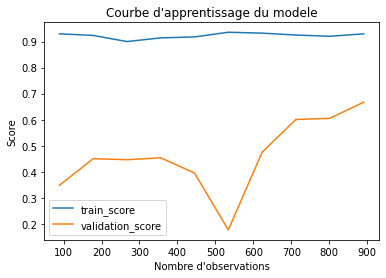

In [ ]:
N, train_score, val_score = learning_curve(XGB_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_XGB)

,0
4.355328e+06,1.310237e+06
4.915918e+06,2.109094e+06
2.020732e+06,2.832228e+06
1.844005e+06,1.103595e+06
3.181654e+06,2.300589e+06
...,...
3.102692e+06,2.001526e+06
1.542585e+07,2.574702e+07
1.622295e+06,8.194931e+05
3.120026e+06,3.612527e+06


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,2.980000e+02
mean,8.992310e+06
std,3.322068e+07
min,0.000000e+00
25%,1.261548e+06
50%,2.486658e+06
75%,7.059453e+06
max,4.716139e+08


In [ ]:
print("KNR MAE :" + str(mean_absolute_error(y_test, y_pred_KNR)))
print("KNR MSE :" +str(mean_squared_error(y_test, y_pred_KNR)))
print("KNR R2" +str(r2_score(y_test, y_pred_KNR)))

print("RFR MAE :" + str(mean_absolute_error(y_test, y_pred_RFR)))
print("RFR MSE :" +str(mean_squared_error(y_test, y_pred_RFR)))
print("RFR R2 :" +str(r2_score(y_test, y_pred_RFR)))

print("SVR MAE :" + str(mean_absolute_error(y_test, y_pred_SVR)))
print("SVR MSE :" +str(mean_squared_error(y_test, y_pred_SVR)))
print("SVR R2 :" +str(r2_score(y_test, y_pred_SVR)))

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))

print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GBR)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GBR)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GBR)))

print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

KNR MAE :5789576.372093087
KNR MSE :784954042371543.4
KNR R20.28634695530766696
RFR MAE :4256126.5440265825
RFR MSE :463449446684305.6
RFR R2 :0.5786478050511381
SVR MAE :7063527.567208325
SVR MSE :1109432635709489.4
SVR R2 :-0.008657750156991995
ADA MAE :8101127.936307238
ADA MSE :759897885200883.4
ADA R20.30912714610598047
GB MAE :5514324.135945194
GB MSE :742341011128421.0
GB R2 :0.32508924829382047
XGB MAE :4994504.07757
XGB MSE :588968849491974.9
XGB R2 :0.4645299087842165


**Le modele donnant les meilleurs resultats est le modele de randomforestregressor**

### Integration de l'Energy star score dans la modelisation

In [ ]:
df_modelisation = df_Building_energy.copy()

# supression des colonnes non utilisées pour la modelisation

del df_modelisation["BuildingType"]
del df_modelisation["PropertyName"]
del df_modelisation["Address"]
del df_modelisation["DefaultData"]
del df_modelisation["SteamUse(kBtu)"]
del df_modelisation["NaturalGas(kBtu)"]
del df_modelisation["Electricity(kBtu)"]
del df_modelisation["SiteEUI(kBtu/sf)"]
del df_modelisation['SiteEUIWN(kBtu/sf)']
del df_modelisation['SourceEUI(kBtu/sf)']
del df_modelisation['SourceEUIWN(kBtu/sf)']
del df_modelisation['SiteEnergyUse(kBtu)']


# imputation des Nan des aires des usages secondaires et tertiaires par 0

df_modelisation['ThirdLargestPropertyUseTypeGFA'] = df_modelisation['ThirdLargestPropertyUseTypeGFA'].fillna(0)
df_modelisation['SecondLargestPropertyUseTypeGFA'] = df_modelisation['SecondLargestPropertyUseTypeGFA'].fillna(0)

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'Outlier',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'part_SteamUse',
       'part_NaturalGas', 'part_Electricity'],
      dtype='object')

**Suppression des outliers**

In [ ]:
df_modelisation["Outlier"].value_counts()

non outlier     1498
Low outlier       13
High outlier       2
Name: Outlier, dtype: int64

In [ ]:
df_modelisation[df_modelisation["Outlier"]=="Low outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity
320,Retail Store,98105.0,4,NORTHEAST,47.66178,-122.31812,1987,2,69492,0,69492,Retail Store,69800.0,Other,0.0,no tertiary use,0.0,100.0,3.189628e+05,Low outlier,2.22,0.03,0.0,0.000000,1.000000
383,Large Office,98104.0,2,DOWNTOWN,47.59878,-122.33458,1913,7,154159,0,154159,Office,193154.0,no secondary use,0.0,no tertiary use,0.0,100.0,1.134876e+07,Low outlier,29.43,0.19,0.0,0.175759,0.824241
628,K-12 School,98109.0,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1,35805,0,35805,K-12 School,35805.0,no secondary use,0.0,no tertiary use,0.0,100.0,4.314717e+05,Low outlier,11.54,0.32,0.0,0.428403,0.571597
693,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1,39900,0,39900,Retail Store,25000.0,Non-Refrigerated Warehouse,15000.0,no tertiary use,0.0,100.0,1.454688e+05,Low outlier,5.46,0.14,0.0,0.663124,0.336876
775,Small- and Mid-Sized Office,98101.0,7,DOWNTOWN,47.61119,-122.33581,1903,3,57720,0,57720,Office,25000.0,no secondary use,0.0,no tertiary use,0.0,NaN,2.410550e+04,Low outlier,0.17,0.00,0.0,0.000000,1.000000
817,Other,98101.0,7,DOWNTOWN,47.60711,-122.33886,1900,3,49760,0,49760,Other,24019.0,no secondary use,0.0,no tertiary use,0.0,NaN,4.429350e+04,Low outlier,0.31,0.01,0.0,0.000000,1.000000
932,Worship Facility,98126.0,1,SOUTHWEST,47.51709,-122.37797,1971,1,23772,0,23772,Worship Facility,23772.0,no secondary use,0.0,no tertiary use,0.0,100.0,1.008417e+05,Low outlier,0.70,0.03,0.0,0.000000,1.000000
1027,Small- and Mid-Sized Office,98133.0,3,CENTRAL,47.59973,-122.31331,1947,1,45068,0,45068,Office,45068.0,no secondary use,0.0,no tertiary use,0.0,100.0,3.092140e+05,Low outlier,8.59,0.19,0.0,0.502263,0.497737
1131,K-12 School,98122.0,3,CENTRAL,47.60885,-122.29990,1929,2,24152,0,24152,K-12 School,24152.0,no secondary use,0.0,no tertiary use,0.0,100.0,1.613634e+05,Low outlier,1.12,0.05,0.0,0.000000,1.000000
1166,Other,98134.0,2,GREATER DUWAMISH,47.58788,-122.33458,1910,3,27690,0,27690,Other,24717.0,Parking,0.0,no tertiary use,0.0,NaN,1.726000e+04,Low outlier,0.12,0.00,0.0,0.000000,1.000000


In [ ]:
df_modelisation[df_modelisation["Outlier"]=="High outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity
167,Large Office,98101.0,7,DOWNTOWN,47.60642,-122.33581,1958,6,172842,25920,146922,Office,99890.0,Data Center,39336.0,Parking,25000.0,NaN,41650404.0,High outlier,362.66,2.10,0.0,0.038765,0.961235
445,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,4,129551,42500,87051,Office,82273.0,Parking,42500.0,Data Center,4778.0,1.0,27137190.0,High outlier,189.18,1.46,0.0,0.000000,1.000000


In [ ]:
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='Low outlier'].index, inplace=True)
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='High outlier'].index, inplace=True)
del df_modelisation['Outlier']

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'part_SteamUse', 'part_NaturalGas',
       'part_Electricity'],
      dtype='object')

In [ ]:
# création des 3 classes de batiments par étage

In [ ]:
df_modelisation['NumberofFloors'].unique()

array([ 2,  8, 11,  6,  5, 10, 19,  7,  1,  3, 12,  4, 15, 25, 33, 23, 17,
       20, 36, 16, 22, 47, 41, 29, 34, 14, 49, 37, 42, 63, 13, 18, 24, 21,
       55, 46, 30, 56,  9,  0, 76, 27, 99], dtype=int64)

In [ ]:
df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors']


In [ ]:
classes = {range(1, 2): 1, range(3, 6): 2, range(7, 1000): 3}

df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors'].apply(lambda x: next((v for k, v in classes.items() if x in k), 0))

In [ ]:
df_modelisation['ENERGYSTARScore'].describe()

count    963.000000
mean      65.735202
std       28.380828
min        1.000000
25%       49.000000
50%       74.000000
75%       89.000000
max      100.000000
Name: ENERGYSTARScore, dtype: float64

In [ ]:
df_X, df_y = preprocessing_energy(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

**KNR ENERGYSTARSCORE**

In [ ]:
hyper_params_KNR = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10],
                'weights':["uniform", "distance"],
                'algorithm':["auto", "ball_tree", "kd_tree", "brute"]
               }

In [ ]:
KNR_model = KNeighborsRegressor()
grid_KNR = GridSearchCV(KNR_model, hyper_params_KNR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_KNR.fit(X_train,y_train)
print(grid_KNR.best_params_)

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
Wall time: 3.38 s


In [ ]:
%%time
KNR_model = grid_KNR.best_estimator_
KNR_model.fit(X_train,y_train)
y_pred_KNR = KNR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_KNR))
print(mean_squared_error(y_test, y_pred_KNR))
print(r2_score(y_test, y_pred_KNR))

4926734.930015937
384208582328692.25
0.4476249307633894
Wall time: 5.2 ms


**RFR ENERGYSTARSCORE**

In [ ]:
hyper_params_RFR = {'n_estimators' : [20, 50, 100, 150],
                'criterion':["squared_error", "absolute_error"]
               }

In [ ]:
RFR_model = RandomForestRegressor()
grid_RFR = GridSearchCV(RFR_model, hyper_params_RFR, scoring = "r2", cv = 4)

In [ ]:
grid_RFR.fit(X_train,y_train)
print(grid_RFR.best_params_)

{'criterion': 'absolute_error', 'n_estimators': 100}


In [ ]:
%%time
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred_RFR = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_RFR))
print(mean_squared_error(y_test, y_pred_RFR))
print(r2_score(y_test, y_pred_RFR))

2791448.937414761
106049932596064.7
0.8475324561850255
Wall time: 13.2 s


**SVR ENERGYSTARSCORE**

In [ ]:
hyper_params_SVR = {'gamma' : ["scale", "auto"],
                'C':[1, 10, 100, 1000, 10000, 100000]
               }

In [ ]:
SVR_model = SVR()
grid_SVR = GridSearchCV(SVR_model, hyper_params_SVR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_SVR.fit(X_train,y_train)
print(grid_SVR.best_params_)

{'C': 100000, 'gamma': 'scale'}
Wall time: 2.18 s


In [ ]:
%%time
SVR_model = grid_SVR.best_estimator_
SVR_model.fit(X_train,y_train)
y_pred_SVR = SVR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_SVR))
print(mean_squared_error(y_test, y_pred_SVR))
print(r2_score(y_test, y_pred_SVR))

5686991.789488635
657389463336204.1
0.05487392258432555
Wall time: 66.4 ms


**ADA ENERGYSTARSCORE**

In [ ]:
hyper_params_ADA = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
ADA_model = AdaBoostRegressor()
grid_ADA = GridSearchCV(ADA_model, hyper_params_ADA, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_ADA.fit(X_train,y_train)
print(grid_ADA.best_params_)

{'learning_rate': 1, 'n_estimators': 10}
Wall time: 9.28 s


In [ ]:
%%time
ADA_model = grid_ADA.best_estimator_
ADA_model.fit(X_train,y_train)
y_pred_ADA = ADA_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_ADA))
print(mean_squared_error(y_test, y_pred_ADA))
print(r2_score(y_test, y_pred_ADA))

5623677.675646407
140503768717133.38
0.797998320332327
Wall time: 48.8 ms


**GBR ENERGYSTARSCORE**

In [ ]:
hyper_params_GBR = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
GB_model = GradientBoostingRegressor()
grid_GBR = GridSearchCV(GB_model , hyper_params_GBR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_GBR.fit(X_train,y_train)
print(grid_GBR.best_params_)

{'learning_rate': 1, 'n_estimators': 30}
Wall time: 8.88 s


overflow encountered in square


In [ ]:
%%time
GBR_model = grid_GBR.best_estimator_
GBR_model.fit(X_train,y_train)
y_pred_GBR = GBR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_GBR))
print(mean_squared_error(y_test, y_pred_GBR))
print(r2_score(y_test, y_pred_GBR))

7050648.732072021
836911189342340.4
-0.2032237108185655
Wall time: 78.4 ms


**XGB ENERGYSTARSCORE**

In [ ]:
param_grid_XGB={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],}

In [ ]:
XGB_model = xgb.XGBRegressor()
grid_XGB = GridSearchCV(XGB_model, param_grid_XGB, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_XGB.fit(X_train,y_train)
XGB_model = grid_XGB.best_estimator_
XGB_model.fit(X_train,y_train)
y_pred_XGB = XGB_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_XGB))
print(mean_squared_error(y_test, y_pred_XGB))
print(r2_score(y_test, y_pred_XGB))

3114005.091748698
121066781119195.62
0.8259427959738859
Wall time: 3min 19s


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,1.920000e+02
mean,8.135780e+06
std,2.644237e+07
min,0.000000e+00
25%,1.180987e+06
50%,2.236926e+06
75%,5.754571e+06
max,2.959299e+08


In [ ]:
print("KNR MAE :" + str(mean_absolute_error(y_test, y_pred_KNR)))
print("KNR MSE :" +str(mean_squared_error(y_test, y_pred_KNR)))
print("KNR R2" +str(r2_score(y_test, y_pred_KNR)))

print("RFR MAE :" + str(mean_absolute_error(y_test, y_pred_RFR)))
print("RFR MSE :" +str(mean_squared_error(y_test, y_pred_RFR)))
print("RFR R2 :" +str(r2_score(y_test, y_pred_RFR)))

print("SVR MAE :" + str(mean_absolute_error(y_test, y_pred_SVR)))
print("SVR MSE :" +str(mean_squared_error(y_test, y_pred_SVR)))
print("SVR R2 :" +str(r2_score(y_test, y_pred_SVR)))

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))

print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GBR)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GBR)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GBR)))

print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

KNR MAE :4926734.930015937
KNR MSE :384208582328692.25
KNR R20.4476249307633894
RFR MAE :2791448.937414761
RFR MSE :106049932596064.7
RFR R2 :0.8475324561850255
SVR MAE :5686991.789488635
SVR MSE :657389463336204.1
SVR R2 :0.05487392258432555
ADA MAE :5623677.675646407
ADA MSE :140503768717133.38
ADA R20.797998320332327
GB MAE :7050648.732072021
GB MSE :836911189342340.4
GB R2 :-0.2032237108185655
XGB MAE :3114005.091748698
XGB MSE :121066781119195.62
XGB R2 :0.8259427959738859


**Nous obtenons de bien meilleurs resultats avec integration de l'energystarscore**

#### Selection de features par model.features_importance

In [ ]:
pd.set_option('display.max_rows', 50)
features_rfr = pd.DataFrame(RFR_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)
features_rfr

,0
PropertyGFATotal,0.271731
LargestPropertyUseTypeGFA,0.110584
ENERGYSTARScore,0.093015
PropertyGFABuilding(s),0.090687
SecondLargestPropertyUseTypeGFA,0.048790
...,...
LargestPropertyUseType_Other/Specialty Hospital,0.000000
LargestPropertyUseType_Other - Utility,0.000000
LargestPropertyUseType_Other - Services,0.000000
LargestPropertyUseType_Other - Restaurant/Bar,0.000000


In [ ]:
features_rfr.shape

(240, 1)

<AxesSubplot:title={'center':'Importance des Features dans le modèle RandomforestRegressor'}>

<Figure size 1440x720 with 0 Axes>

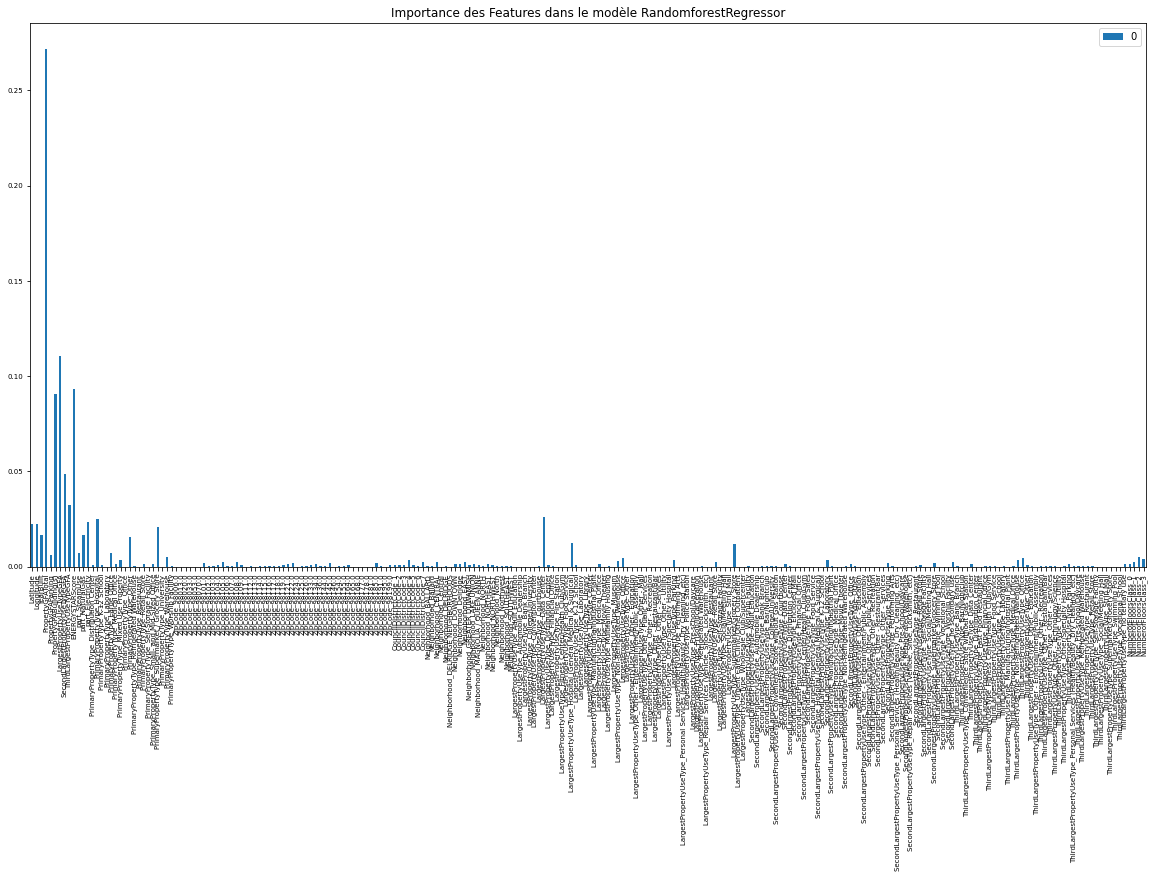

In [ ]:
pd.set_option('display.max_rows', 60)

plt.figure(figsize= (20,10))
pd.DataFrame(RFR_model.feature_importances_,
             index = df_X.columns).plot.bar(figsize= (20,10),
                                            fontsize=7,
                                            title ="Importance des Features dans le modèle RandomforestRegressor")

In [ ]:
features_rfr.columns=["feature_importance"]

In [ ]:
features_rfr.columns

Index(['feature_importance'], dtype='object')

In [ ]:
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)
features_rfr.head(20)

,feature_importance
PropertyGFATotal,0.271731
LargestPropertyUseTypeGFA,0.110584
ENERGYSTARScore,0.093015
PropertyGFABuilding(s),0.090687
SecondLargestPropertyUseTypeGFA,0.048790
ThirdLargestPropertyUseTypeGFA,0.032244
LargestPropertyUseType_Data Center,0.025946
PrimaryPropertyType_Hospital,0.024778
part_Electricity,0.023526
Latitude,0.022473


In [ ]:
# création d'un dictionnaire des variables selectionnées selon leur nombre

d_feat_imp = {}
for i in range (1,241):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

In [ ]:
%%time
d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_energy(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
    RFR_model.fit(X_train,y_train)
    y_pred = RFR_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)

Wall time: 40min 20s


In [ ]:
# Quel est le nombre de variables pour la MAE minimale

n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
n

177

In [ ]:
# Quel est le nombre de variables pour les 10 MAE minimales
from operator import itemgetter 
  
K = 10

  
res = dict(sorted(d_n_feat_imp_MAE.items(), key = itemgetter(1))[:K]) 
  
print(str(res)) 

{177: 1590513.8620569033, 221: 1638215.1312387437, 63: 1679293.5513638072, 213: 1694531.106543828, 56: 1708361.4603556844, 130: 1708685.9724370732, 66: 1740863.9395852622, 168: 1795873.475735172, 71: 1796040.8594206197, 157: 1840971.623760133}


In [ ]:
# recupérons ne nombre de variable minimal sur ces 10 plus faibles valeurs de MAE
A = res.keys()
n = min(A)
n

56

Text(0, 0.5, 'Mean absolute error')

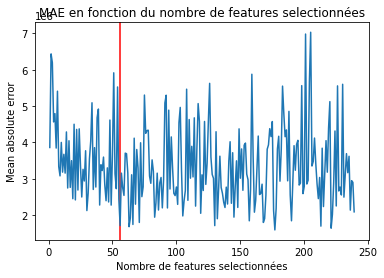

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
n

56

In [ ]:
features_a_conserver_imp = features_rfr.head(n).index.tolist()
features_a_conserver_imp

['PropertyGFATotal',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'PropertyGFABuilding(s)',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'LargestPropertyUseType_Data Center',
 'PrimaryPropertyType_Hospital',
 'part_Electricity',
 'Latitude',
 'Longitude',
 'PrimaryPropertyType_Supermarket / Grocery Store',
 'part_NaturalGas',
 'YearBuilt',
 'PrimaryPropertyType_Other',
 'LargestPropertyUseType_Hospital (General Medical & Surgical)',
 'LargestPropertyUseType_Supermarket/Grocery Store',
 'part_SteamUse',
 'PrimaryPropertyType_Large Office',
 'PropertyGFAParking',
 'PrimaryPropertyType_Warehouse',
 'NumberofFloorsClass_2',
 'ThirdLargestPropertyUseType_Office',
 'LargestPropertyUseType_Office',
 'NumberofFloorsClass_3',
 'LargestPropertyUseType_Parking',
 'ThirdLargestPropertyUseType_Non-Refrigerated Warehouse',
 'CouncilDistrictCode_4',
 'PrimaryPropertyType_Mixed Use Property',
 'SecondLargestPropertyUseType_Laboratory',
 'LargestPropertyUseType_Non-Refr

In [ ]:
# Nous conserverons les features selectionnées

df_X,df_y= preprocessing_energy(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
grid_RFR.fit(X_train,y_train)
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

3007680.1714485143
104701858685392.2
0.84947057639887


In [ ]:
pd.DataFrame(y_test, y_pred)

,0
1.943984e+06,1817756.125
1.773341e+06,1924436.000
2.540778e+06,1243027.750
3.113410e+06,2912179.500
3.307576e+06,4138032.750
...,...
1.257251e+06,735187.125
3.074774e+06,3647345.750
2.540267e+06,1167543.250
1.796245e+06,2959193.750


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,1.920000e+02
mean,8.135780e+06
std,2.644237e+07
min,0.000000e+00
25%,1.180987e+06
50%,2.236926e+06
75%,5.754571e+06
max,2.959299e+08


In [ ]:
pd.DataFrame(y_test, y_pred).reset_index().describe()

,index,0
count,1.920000e+02,1.920000e+02
mean,8.218073e+06,8.135780e+06
std,1.979863e+07,2.644237e+07
min,5.222143e+05,0.000000e+00
25%,1.670397e+06,1.180987e+06
50%,2.612607e+06,2.236926e+06
75%,6.930710e+06,5.754571e+06
max,1.940279e+08,2.959299e+08


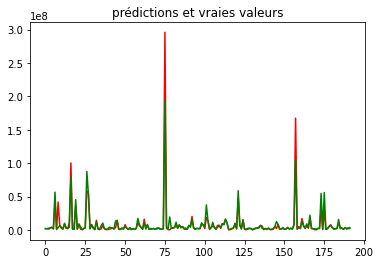

In [ ]:
plt.title("prédictions et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')

##### Score des différents modeles apres feature selection attribut feature (ADABoost, GBR, et XGBR)

In [ ]:
%%time
#ADA

df_X, df_y = preprocessing_energy(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_ADA.fit(X_train,y_train)
ADA_model = grid_ADA.best_estimator_
ADA_model.fit(X_train,y_train)

features_rfr = pd.DataFrame(ADA_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)

features_rfr.columns=["feature_importance"]
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_energy(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
#    grid_ADA.fit(X_train,y_train)
#    ADA_model = grid_ADA.best_estimator_
    ADA_model.fit(X_train,y_train)
    y_pred = ADA_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)
    
n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
    
features_a_conserver_imp = features_rfr.head(n).index.tolist()

df_X,df_y= preprocessing_energy(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_ADA.fit(X_train,y_train)
ADA_model = grid_ADA.best_estimator_
y_pred_ADA = ADA_model.predict(X_test)

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))


ADA MAE :16426006.225978946
ADA MSE :291511992543327.5
ADA R20.5808944295610083
Wall time: 28.9 s


In [ ]:
n

106

Text(0, 0.5, 'Mean absolute error')

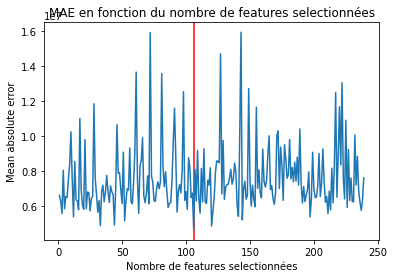

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
%%time
#GBR

df_X, df_y = preprocessing_energy(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_GBR.fit(X_train,y_train)
GBR_model = grid_GBR.best_estimator_
GBR_model.fit(X_train,y_train)

features_rfr = pd.DataFrame(GBR_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)
features_rfr.columns=["feature_importance"]
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_energy(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
#    grid_GBR.fit(X_train,y_train)
#    GBR_model = grid_GBR.best_estimator_
    GBR_model.fit(X_train,y_train)
    y_pred = GBR_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)
    
n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
    
features_a_conserver_imp = features_rfr.head(n).index.tolist()

df_X,df_y= preprocessing_energy(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_GBR.fit(X_train,y_train)
GBR_model = grid_GBR.best_estimator_
y_pred_GB = GBR_model.predict(X_test)


print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GB)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GB)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GB)))

overflow encountered in square


GB MAE :5138706.276655844
GB MSE :391858383244318.8
GB R2 :0.43662684403454954
Wall time: 28.4 s


overflow encountered in square


In [ ]:
n

166

Text(0, 0.5, 'Mean absolute error')

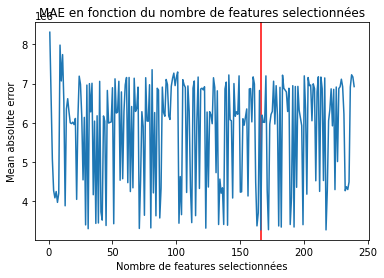

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
%%time
# XGB

df_X, df_y = preprocessing_energy(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_XGB.fit(X_train,y_train)
XGB_model = grid_XGB.best_estimator_
XGB_model.fit(X_train,y_train)


features_rfr = pd.DataFrame(XGB_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)

features_rfr.columns=["feature_importance"]
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_energy(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
#    grid_XGB.fit(X_train,y_train)
#    XGB_model = grid_XGB.best_estimator_
    XGB_model.fit(X_train,y_train)
    y_pred = XGB_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)
    
n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
    
features_a_conserver_imp = features_rfr.head(n).index.tolist()

df_X,df_y= preprocessing_energy(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_XGB.fit(X_train,y_train)
XGB_model = grid_XGB.best_estimator_
#XGB_model.fit(X_train,y_train)
y_pred_XGB = XGB_model.predict(X_test)


print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

XGB MAE :2744872.259352539
XGB MSE :82692182674015.53
XGB R2 :0.8811137953945838
Wall time: 6min 8s


In [ ]:
n

66

Text(0, 0.5, 'Mean absolute error')

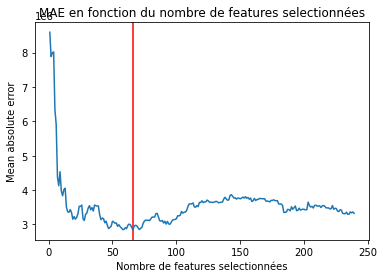

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
%%time


print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))

print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GB)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GB)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GB)))

print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

ADA MAE :16426006.225978946
ADA MSE :291511992543327.5
ADA R20.5808944295610083
GB MAE :5138706.276655844
GB MSE :391858383244318.8
GB R2 :0.43662684403454954
XGB MAE :2744872.259352539
XGB MSE :82692182674015.53
XGB R2 :0.8811137953945838
Wall time: 5 ms


#### Shap

In [ ]:
df_X,df_y= preprocessing_energy(df_modelisation)
df_X = df_X
X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
grid_RFR.fit(X_train,y_train)
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

2936034.8394103707
109951454975100.45
0.8419232538054587


In [ ]:
shap.initjs()

In [ ]:
#TreeExplainer, TreeGainExplainer, TreeMapleExplainer 

In [ ]:
X_test_shap = pd.DataFrame(X_test, columns = df_X.columns)

In [ ]:
tree_explainer1 = shap.TreeExplainer(RFR_model)

#### Shap global

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


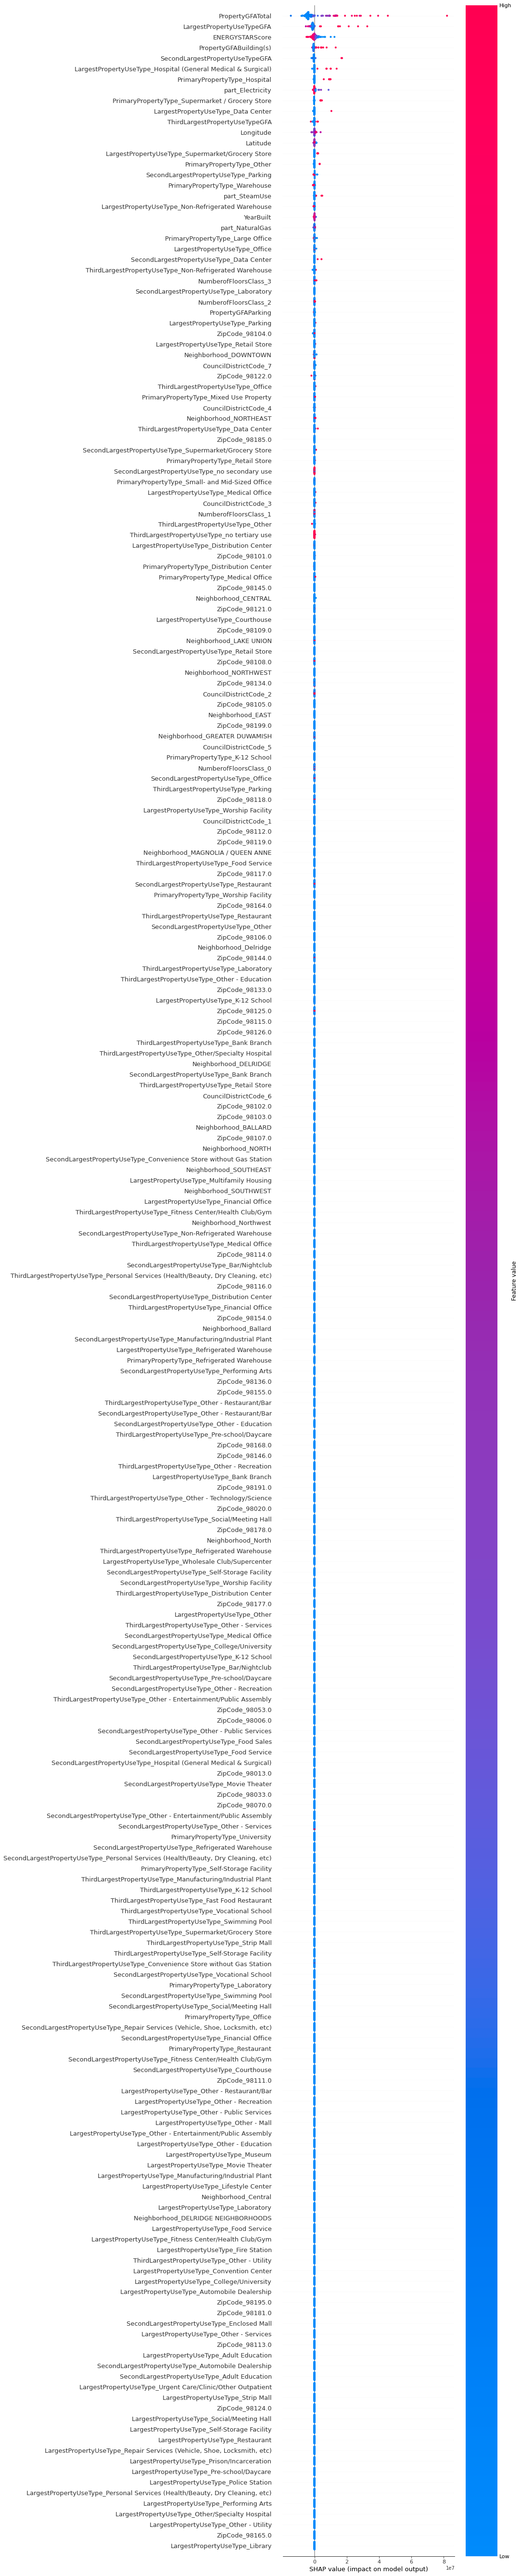

In [ ]:
shap_values = tree_explainer1.shap_values(X_test_shap)
shap.summary_plot(shap_values, X_test_shap, max_display = 300)

##### Selection des features par shap

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_test_shap.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(20)

,col_name,feature_importance_vals
3,PropertyGFATotal,6.133958e+06
6,LargestPropertyUseTypeGFA,1.913646e+06
9,ENERGYSTARScore,1.193736e+06
5,PropertyGFABuilding(s),7.419003e+05
7,SecondLargestPropertyUseTypeGFA,5.559133e+05
116,LargestPropertyUseType_Hospital (General Medic...,3.762331e+05
14,PrimaryPropertyType_Hospital,3.528508e+05
12,part_Electricity,3.383961e+05
27,PrimaryPropertyType_Supermarket / Grocery Store,3.128584e+05
110,LargestPropertyUseType_Data Center,2.666450e+05


In [ ]:
feature_importance.shape

(240, 2)

In [ ]:
# création d'un dictionnaire des variables selectionnées selon leur nombre

d_feat_shap = {}
for i in range (1,241):
    d_feat_shap[i] = feature_importance["col_name"].head(i).tolist()

In [ ]:
d_n_feat_shap_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_energy(df_modelisation)
    df_X = df_X[d_feat_shap.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
    RFR_model.fit(X_train,y_train)
    y_pred = RFR_model.predict(X_test)
    d_n_feat_shap_MAE[i] = mean_absolute_error(y_test, y_pred)

In [ ]:
# Quel est le nombre de variables pour lequel la MAE est minimale

n = min(d_n_feat_shap_MAE, key=d_n_feat_shap_MAE.get)
n

205

In [ ]:
from operator import itemgetter 
  
K = 10

  
res = dict(sorted(d_n_feat_shap_MAE.items(), key = itemgetter(1))[:K]) 
  
print(str(res)) 

{205: 1634151.466092677, 12: 1669998.2637250002, 158: 1705221.873033731, 38: 1813898.4982942436, 40: 1820672.3747304396, 31: 1836934.4682774332, 53: 1869630.904527848, 232: 1939121.0025879648, 70: 1953021.5612251041, 22: 1981770.9479425575}


In [ ]:
# recupérons ne nombre de variable minimal sur ces 10 plus faibles valeurs de MAE
A = res.keys()
n = min(A)
n

12

Text(0, 0.5, 'Mean absolute error')

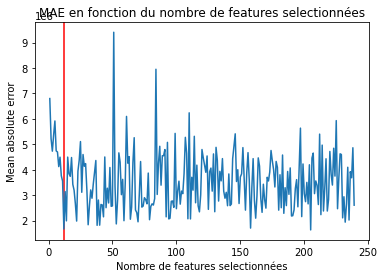

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_shap_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
features_a_conserver_shap = feature_importance["col_name"].head(n).tolist()
features_a_conserver_shap

['PropertyGFATotal',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'PropertyGFABuilding(s)',
 'SecondLargestPropertyUseTypeGFA',
 'LargestPropertyUseType_Hospital (General Medical & Surgical)',
 'PrimaryPropertyType_Hospital',
 'part_Electricity',
 'PrimaryPropertyType_Supermarket / Grocery Store',
 'LargestPropertyUseType_Data Center',
 'ThirdLargestPropertyUseTypeGFA',
 'Longitude']

##### Modele random forest regressor avec features shap

In [ ]:
df_X,df_y= preprocessing_energy(df_modelisation)
df_X = df_X[features_a_conserver_shap]
X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
grid_RFR.fit(X_train,y_train)
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

3404076.7263580672
145336559228565.78
0.7910502376602051


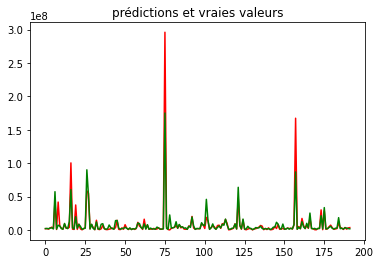

In [ ]:
plt.title("prédictions et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')

In [ ]:
pd.DataFrame(y_test).describe()

,0
count,1.920000e+02
mean,8.135780e+06
std,2.644237e+07
min,0.000000e+00
25%,1.180987e+06
50%,2.236926e+06
75%,5.754571e+06
max,2.959299e+08


#### Comparaison avec modeles naïf

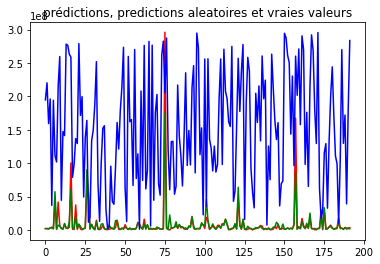

In [ ]:
y_pred_random = np.random.uniform(np.min(y_test),np.max(y_test),y_test.shape)

plt.title("prédictions, predictions aleatoires et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')
plt.plot(y_pred_random, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_random))
print(mean_squared_error(y_test, y_pred_random))
print(r2_score(y_test, y_pred_random))

146510323.13055333
2.843894312001453e+16
-39.886549383467354


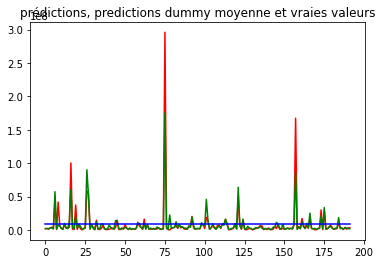

In [ ]:
dummy_reg = DummyRegressor(strategy = 'mean')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)


plt.title("prédictions, predictions dummy moyenne et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

9628588.431046603
695609455554060.9
-7.48001110464358e-05


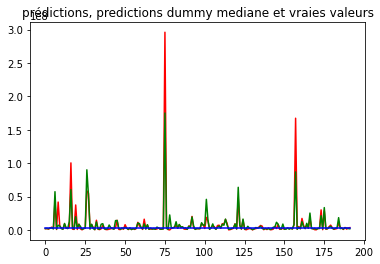

In [ ]:
dummy_reg = DummyRegressor(strategy = 'median')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)



plt.title("prédictions, predictions dummy mediane et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

6964191.2598802075
725967361489686.1
-0.043720234295344884


# Modele selectionné : XGBOOST avec feature selection

In [ ]:
print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

XGB MAE :2744872.259352539
XGB MSE :82692182674015.53
XGB R2 :0.8811137953945838


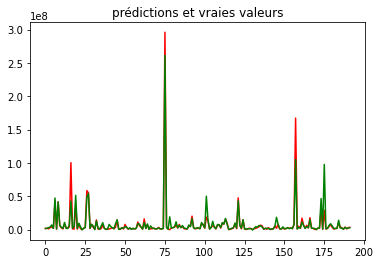

In [ ]:
plt.title("prédictions et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')

In [ ]:
pd.DataFrame(y_test).describe()

,0
count,1.920000e+02
mean,8.135780e+06
std,2.644237e+07
min,0.000000e+00
25%,1.180987e+06
50%,2.236926e+06
75%,5.754571e+06
max,2.959299e+08


In [ ]:
pd.DataFrame(y_test, y_pred_XGB)

,0
1.569731e+06,1817756.125
2.050731e+06,1924436.000
2.934918e+06,1243027.750
4.037813e+06,2912179.500
6.974612e+06,4138032.750
...,...
6.368128e+05,735187.125
3.477567e+06,3647345.750
1.725947e+06,1167543.250
2.248234e+06,2959193.750


#### Comparaison avec modeles naïf

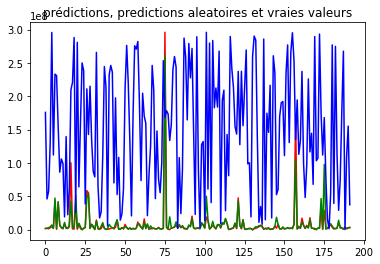

In [ ]:
y_pred_random = np.random.uniform(np.min(y_test),np.max(y_test),y_test.shape)

plt.title("prédictions, predictions aleatoires et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')
plt.plot(y_pred_random, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_random))
print(mean_squared_error(y_test, y_pred_random))
print(r2_score(y_test, y_pred_random))

145049763.11418393
2.913531985353712e+16
-40.887727295899374


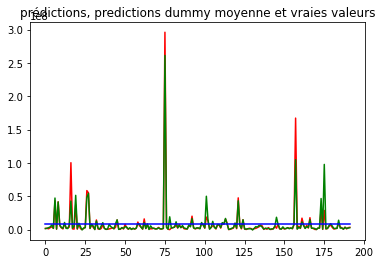

In [ ]:
dummy_reg = DummyRegressor(strategy = 'mean')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)


plt.title("prédictions, predictions dummy moyenne et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

9628588.431046603
695609455554060.9
-7.48001110464358e-05


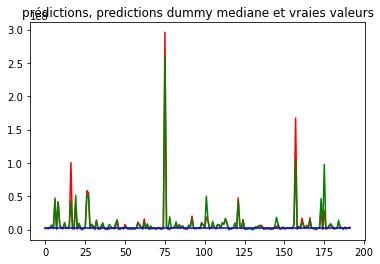

In [ ]:
dummy_reg = DummyRegressor(strategy = 'median')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)



plt.title("prédictions, predictions dummy mediane et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

6964191.2598802075
725967361489686.1
-0.043720234295344884
